<a href="https://colab.research.google.com/github/hsyni/game-character-DCGAN/blob/main/CharacterDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil

# Kaynak klasör (Drive içindeki klasör)
source_folder = '/content/drive/MyDrive/YapayZeka/GAN/data/animePortraits_1990/'  # Burayı değiştirin

# Hedef klasör (Colab içindeki klasör)
target_folder = '/content/raw/'

# Hedef klasörü oluştur
os.makedirs(target_folder, exist_ok=True)

# Dosyaları kopyala
for filename in os.listdir(source_folder):
    file_path = os.path.join(source_folder, filename)
    if os.path.isfile(file_path):  # Sadece dosyaları kopyalar
        shutil.copy(file_path, target_folder)

print("Resimler başarıyla kopyalandı!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Resimler başarıyla kopyalandı!


In [ ]:
# Hedef klasör yolunu belirtin
folder_path = '/content/raw'  # Buraya klasör yolunu yazın

# Dosyaları listeleyin
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(f"Klasördeki dosyaların sayısı: {len(files)}")
else:
    print("Klasör bulunamadı. Yolun doğru olduğundan emin olun.")

Klasördeki dosyaların sayısı: 12457


In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import glob as gb
import matplotlib.pyplot as plt

# Klasör yolları
input_folder = "/content/raw/"  # Eğitim seti
weights_dir = "/content/weights/"  # Ağırlıklar kaydedilecek klasör
samples_dir = "/content/samples/"  # Örnek görüntüler kaydedilecek klasör
log_dir = "/content/logs"  # TensorBoard logları için klasör
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Görüntü boyutları
IMG_H = 128
IMG_W = 128
IMG_C = 3

# Batch boyutu
BATCH_SIZE = 32

# Latent boyutu
LATENT_DIM = 100

# Eğitim parametreleri
EPOCHS = 50
SAVE_FREQUENCY = 10

# Weight initialization
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Görüntü yükleme ve ön işleme
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_H, IMG_W])
    image = tf.image.random_flip_left_right(image)  # Yatay çevirme
    image = (image - 127.5) / 127.5  # Normalize et: [0, 255] -> [-1, 1]
    return image

def tf_dataset(image_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.shuffle(buffer_size=512)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.cache()  # Ön belleğe al
    return dataset

# Generator modeli
def build_generator(latent_dim):
    initial_h = IMG_H // 16
    initial_w = IMG_W // 16
    initial_filters = 512

    noise = Input(shape=(latent_dim,), name="generator_noise_input")
    x = Dense(initial_h * initial_w * initial_filters, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((initial_h, initial_w, initial_filters))(x)

    filters = [512, 256, 128, 64]
    for f in filters:
        x = Conv2DTranspose(f, 5, strides=2, padding="same", kernel_initializer=w_init, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(3, 5, strides=1, padding="same", activation="tanh", kernel_initializer=w_init)(x)
    return Model(noise, x, name="generator")

# Discriminator modeli
def build_discriminator():
    filters = [64, 128, 256, 512, 1024]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C), name="images")
    x = image_input

    for f in filters:
        x = Conv2D(f, 5, strides=2, padding="same", kernel_initializer=w_init)(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(image_input, x, name="discriminator")

# GAN Modeli
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        with tf.GradientTape() as tape:
            pred_fake = self.discriminator(generated_images)
            pred_real = self.discriminator(real_images)
            d_loss_real = self.loss_fn(tf.ones_like(pred_real) * 0.9, pred_real)
            d_loss_fake = self.loss_fn(tf.zeros_like(pred_fake), pred_fake)
            d_loss = d_loss_real + d_loss_fake
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        grads = [tf.clip_by_value(g, -5.0, 5.0) for g in grads]
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

# Veri seti
image_files = gb.glob(input_folder + "*.jpg") + gb.glob(input_folder + "*.jpeg") + gb.glob(input_folder + "*.png")
if len(image_files) == 0:
    raise ValueError("Veri seti boş! Lütfen veri yolunu kontrol edin.")

print(f"Veri setindeki toplam görüntü sayısı: {len(image_files)}")
dataset = tf_dataset(image_files, BATCH_SIZE)

# Model oluşturma
d_model = build_discriminator()
g_model = build_generator(LATENT_DIM)
gan = GAN(d_model, g_model, LATENT_DIM)

# Ağırlıkları yükleme
if os.path.exists(os.path.join(weights_dir, "generator_weights_last.weights.h5")):
    print("Kaydedilmiş ağırlıklar yükleniyor...")
    g_model.load_weights(os.path.join(weights_dir, "generator_weights_last.weights.h5"))
    d_model.load_weights(os.path.join(weights_dir, "discriminator_weights_last.weights.h5"))

# Optimizasyon ve loss
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1)

gan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer, loss_fn=bce_loss_fn)

# Eğitim döngüsü
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    step = 0
    for real_images in dataset:
        step += 1
        losses = gan.train_step(real_images)
        d_loss = losses["d_loss"].numpy()
        g_loss = losses["g_loss"].numpy()
        print(f"Step {step} - d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}")

    if (epoch + 1) % SAVE_FREQUENCY == 0:
        # Ağırlıkları kaydet
        g_model.save_weights(os.path.join(weights_dir, f"generator_weights_epoch_{epoch+1}.weights.h5"))
        d_model.save_weights(os.path.join(weights_dir, f"discriminator_weights_epoch_{epoch+1}.weights.h5"))
        print(f"Ağırlıklar epoch {epoch+1}'de kaydedildi.")

        # Örnek görüntüler üret ve kaydet
        noise = tf.random.normal(shape=(16, LATENT_DIM))
        generated_images = g_model(noise).numpy()
        generated_images = (generated_images + 1) / 2.0
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i])
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(samples_dir, f"generated_epoch_{epoch+1}.png"), format="png", dpi=300)
        plt.close()
        print(f"Örnek görüntüler epoch {epoch+1}'de kaydedildi.")

# Eğitim tamamlandıktan sonra ağırlıkları ve örnek görüntüleri zipleyip local'e indirme
shutil.make_archive("/content/training_results", 'zip', weights_dir)
shutil.make_archive("/content/sample_images", 'zip', samples_dir)
from google.colab import files
files.download("/content/training_results.zip")
files.download("/content/sample_images.zip")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Step 86 - d_loss: 0.6967, g_loss: 3.0706
Step 87 - d_loss: 0.7176, g_loss: 3.6883
Step 88 - d_loss: 0.7507, g_loss: 2.5727
Step 89 - d_loss: 0.6920, g_loss: 2.7863
Step 90 - d_loss: 0.6962, g_loss: 3.7465
Step 91 - d_loss: 0.7014, g_loss: 3.6773
Step 92 - d_loss: 0.8977, g_loss: 1.2298
Step 93 - d_loss: 1.1191, g_loss: 4.8967
Step 94 - d_loss: 0.7500, g_loss: 3.3558
Step 95 - d_loss: 0.7762, g_loss: 1.9924
Step 96 - d_loss: 0.7943, g_loss: 3.3828
Step 97 - d_loss: 0.7449, g_loss: 3.6061
Step 98 - d_loss: 0.7720, g_loss: 2.7933
Step 99 - d_loss: 0.7850, g_loss: 2.6844
Step 100 - d_loss: 0.7211, g_loss: 3.2041
Step 101 - d_loss: 0.7336, g_loss: 3.0457
Step 102 - d_loss: 0.7487, g_loss: 3.3482
Step 103 - d_loss: 0.7033, g_loss: 3.5456
Step 104 - d_loss: 0.7232, g_loss: 3.0317
Step 105 - d_loss: 0.7103, g_loss: 2.6326
Step 106 - d_loss: 0.7705, g_loss: 3.6912
Step 107 - d_loss: 0.7038, g_loss: 3.1929
Step 108 - d_loss: 0.7346, g_loss: 2.0694
S

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mounted at /content/drive
Ağırlıklar başarıyla yüklendi!
Giriş görüntüsü başarıyla yüklendi.
Adım 0/7000, Kayıp: [128.63953]
Adım 100/7000, Kayıp: [119.9438]
Adım 200/7000, Kayıp: [115.34297]
Adım 300/7000, Kayıp: [111.76152]
Adım 400/7000, Kayıp: [108.207375]
Adım 500/7000, Kayıp: [105.39754]
Adım 600/7000, Kayıp: [103.35377]
Adım 700/7000, Kayıp: [101.6725]
Adım 800/7000, Kayıp: [98.77409]
Adım 900/7000, Kayıp: [96.77028]
Adım 1000/7000, Kayıp: [94.06655]
Adım 1100/7000, Kayıp: [91.78855]
Adım 1200/7000, Kayıp: [89.70336]
Adım 1300/7000, Kayıp: [84.94709]
Adım 1400/7000, Kayıp: [82.311714]
Adım 1500/7000, Kayıp: [79.27569]
Adım 1600/7000, Kayıp: [71.14936]
Adım 1700/7000, Kayıp: [66.89511]
Adım 1800/7000, Kayıp: [62.66167]
Adım 1900/7000, Kayıp: [59.556263]
Adım 2000/7000, Kayıp: [57.43271]
Adım 2100/7000, Kayıp: [55.993423]
Adım 2200/7000, Kayıp: [54.70888]
Adım 2300/7000, Kayıp: [53.288284]
Adım 2400/7000, Kayıp: [52.024464]
Adım 2500/7000, Kayıp: [50.91716]
Adım 2600/7000, Kayıp: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


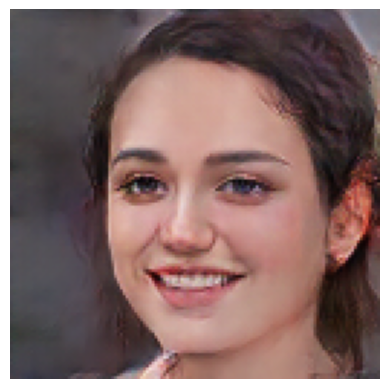

Anime tarzı görüntü başarıyla kaydedildi: /content/generated_anime_image.jpg


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from matplotlib import pyplot as plt

# 1. Google Drive Bağlantısı ve Model Yükleme
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Model yolu ve görüntü yolları
generator_path = "/content/drive/MyDrive/YapayZeka/GAN/data/5306F_7151M_Dataset/12457_Total/training_results/generator_weights_epoch_50.weights.h5"
input_image_path = "/content/portrait.jpg"  # Giriş görüntüsü yolu
output_cropped_path = "/content/cropped_portrait.jpg"  # Kırpılmış yüz görüntüsü
output_anime_path = "/content/generated_anime_image.jpg"  # Üretilen anime görüntüsü

# 2. Generator Modelini Oluştur ve Ağırlıkları Yükle
def build_generator(latent_dim):
    initial_h = 128 // 16  # Orijinal mimariye uygun değer
    initial_w = 128 // 16
    initial_filters = 512

    noise = tf.keras.Input(shape=(latent_dim,), name="generator_noise_input")
    x = tf.keras.layers.Dense(initial_h * initial_w * initial_filters, use_bias=False)(noise)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Reshape((initial_h, initial_w, initial_filters))(x)

    filters = [512, 256, 128, 64]  # Orijinal filtre boyutları
    for f in filters:
        x = tf.keras.layers.Conv2DTranspose(f, 5, strides=2, padding="same", kernel_initializer="random_normal", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2DTranspose(3, 5, strides=1, padding="same", activation="tanh", kernel_initializer="random_normal")(x)
    return tf.keras.Model(noise, x, name="generator")

# Latent boyutunu belirleyin (eğitimde kullandığınız boyut)
LATENT_DIM = 100
generator = build_generator(LATENT_DIM)

try:
    generator.load_weights(generator_path)
    print("Ağırlıklar başarıyla yüklendi!")
except Exception as e:
    raise RuntimeError(f"Ağırlıklar yüklenirken bir hata oluştu: {str(e)}")

# 3. Görüntüyü Normalize Etme
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB'ye dönüştür
    image = (image / 127.5) - 1.0  # Normalize et: [0, 255] -> [-1, 1]
    return np.expand_dims(image, axis=0)

# 4. Latent Vektör Optimizasyonu
def find_latent_vector(generator, target_image, latent_dim, steps=7000, learning_rate=0.0005):  # Daha fazla adım ve düşük öğrenme oranı
    latent_vector = tf.Variable(np.random.normal(size=(1, latent_dim)), trainable=True)
    optimizer = tf.keras.optimizers.AdamW(learning_rate)  # AdamW kullanımı

    # VGG19 modelini yükle ve özellik çıkarıcıyı oluştur
    vgg = VGG19(weights="imagenet", include_top=False)
    vgg.trainable = False
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=[
        vgg.get_layer("block4_conv3").output,  # Çoklu katmanlar için
        vgg.get_layer("block5_conv4").output
    ])

    # Giriş görüntüsünü doğru şekilde işle
    target_image_tensor = tf.convert_to_tensor(target_image, dtype=tf.float32)
    target_image_tensor = tf.image.resize(target_image_tensor, (128, 128))  # Orijinal çözünürlük
    target_image_tensor = tf.expand_dims(target_image_tensor[0], axis=0)  # Batch boyutu ekle
    target_features = feature_extractor(target_image_tensor)

    perceptual_loss_weight = 1.0
    edge_loss_weight = 0.2
    ssim_weight = 0.5

    def loss_fn():
        generated_image = generator(latent_vector)
        generated_image = tf.image.resize(generated_image, (128, 128))  # Orijinal çözünürlük
        generated_features = feature_extractor(generated_image)

        # Çoklu perceptual loss hesaplama
        perceptual_loss = sum([
            tf.reduce_mean(tf.square(tf.stop_gradient(t) - g))
            for t, g in zip(target_features, generated_features)
        ])

        # Edge loss
        target_edges = tf.image.sobel_edges(target_image_tensor)
        generated_edges = tf.image.sobel_edges(generated_image)
        edge_loss = tf.reduce_mean(tf.square(target_edges - generated_edges))

        # SSIM loss
        ssim_loss = 1 - tf.image.ssim(target_image_tensor, generated_image, max_val=1.0)

        # Toplam loss
        return (
            perceptual_loss_weight * perceptual_loss +
            edge_loss_weight * edge_loss +
            ssim_weight * ssim_loss
        )

    for step in range(steps):
        with tf.GradientTape() as tape:
            loss = loss_fn()
        grads = tape.gradient(loss, [latent_vector])
        optimizer.apply_gradients(zip(grads, [latent_vector]))
        if step % 100 == 0:
            print(f"Adım {step}/{steps}, Kayıp: {loss.numpy()}")

    return latent_vector.numpy()

# 5. Anime Görüntüsünü Üretme
def generate_and_save_anime(generator, latent_vector, output_path):
    anime_image = generator.predict(latent_vector)
    anime_image = (anime_image[0] + 1) * 127.5
    anime_image = np.clip(anime_image, 0, 255).astype(np.uint8)

    cv2.imwrite(output_path, anime_image)
    plt.imshow(anime_image)
    plt.axis("off")
    plt.show()

# 6. Süreç
original_image = cv2.imread(input_image_path)
if original_image is not None:
    print("Giriş görüntüsü başarıyla yüklendi.")

    preprocessed_image = preprocess_image(original_image)
    optimized_latent_vector = find_latent_vector(generator, preprocessed_image, LATENT_DIM)
    np.save("/content/optimized_latent_vector.npy", optimized_latent_vector)
    print("Latent vektör başarıyla optimize edildi ve kaydedildi.")

    generate_and_save_anime(generator, optimized_latent_vector, output_anime_path)
    print(f"Anime tarzı görüntü başarıyla kaydedildi: {output_anime_path}")
else:
    print("Giriş görüntüsü yüklenemedi.")


Eğer hala daha net ve anime uyumlu sonuçlar istiyorsanız, mimari değişiklikler (örneğin, CycleGAN veya Pix2Pix) ve yeni bir eğitim süreci düşünmelisiniz.